In [401]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sys
sys.path.append('..')
import clusterizer

import random
import functools
import operator

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [460]:
#circuitnr = random.choice(clusterizer.globals.available_circuits)
circuitnr = 2063
print(circuitnr)
circuit = clusterizer.circuit.MergedCircuit(circuitnr)
circuit.build()

2063


In [461]:
plt.rcParams['figure.figsize'] = [8, 5]

clusterizer.plot.draw_location_time_scatter(circuit)

In [462]:
clusters_poisson = clusterizer.algorithms.clusterize_poisson(circuit, time_bin_size=np.timedelta64(7, 'D'))
#clusterizer.plot.draw_location_time_scatter(circuit)
#clusterizer.plot.overlay_cluster_collection(clusters_poisson)
#plt.show()
#for clust in clusters_poisson:
#    print(clust)

In [463]:
clusters_DBSCAN = clusterizer.algorithms.clusterize_DBSCAN(circuit, binLengthY=1)
#clusterizer.plot.draw_location_time_scatter(circuit)
#clusterizer.plot.overlay_cluster_collection(clusters_DBSCAN)
#plt.show()
#for clust in clusters_DBSCAN:
#    print(clust)

In [464]:
clusters_pinta = clusterizer.algorithms.clusterize_pinta(circuit, timeinterval=np.timedelta64(7, 'D'), sensitivity=10.0)
#clusterizer.plot.draw_location_time_scatter(circuit)
#clusterizer.plot.overlay_cluster_collection(clusters_pinta)
#plt.show()
#for clust in clusters_DBSCAN:
#    print(clust)

# ClusterEnsemble

Een ClusterEnsemble is een set van ClusterSet objecten. Een ClusterSet is een set van Cluster objecten. Deze gestapelde structuur zorgt ervoor dat clusters die bij elkaar horen in dezelfde ClusterSet worden gestopt, en verschillende clusters gescheiden blijven.
Door twee clusters bij elkaar op te tellen met + kun je de resultaten van meerdere algoritmes combineren.

In [465]:
ensemble_combined = clusters_poisson & (clusters_DBSCAN | clusters_pinta)
#ensemble_combined = ensemble_combined.most_confident()

<IPython.core.display.Javascript object>


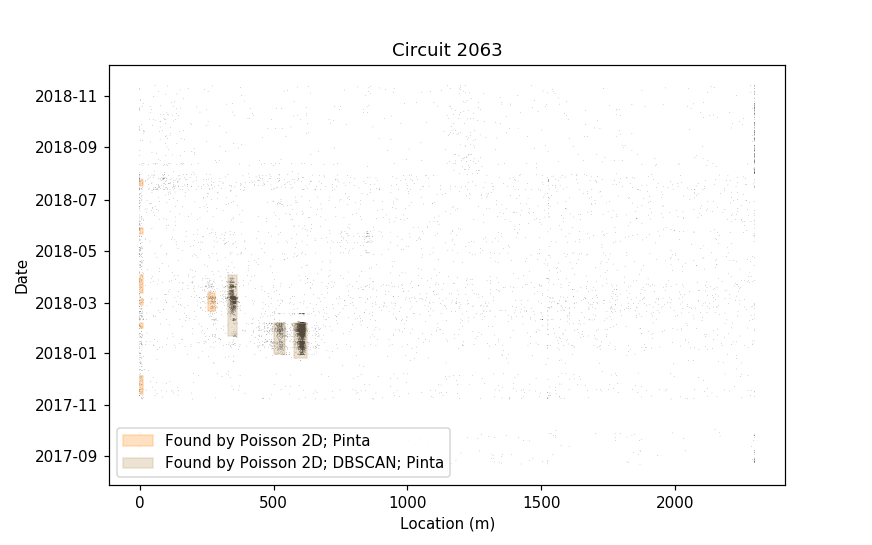

In [466]:
%matplotlib notebook
#%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [8, 5]

ax = plt.gca()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax, dot_size_to_charge_ratio=None)
clusterizer.plot.overlay_cluster_ensemble(ensemble_combined, opacity=.4, scale_opacity_by_found_by_count=False)
clusterizer.plot.legend_without_duplicate_labels()
plt.show()

### clusterize_ensemble

Door algoritmes mee te geven aan clusterize_ensemble kun je in 1 keer meerdere algoritmes toepassen op een circuit. De resultaten van de algoritmes worden gecombineerd in een ClusterEnsemble.

In [467]:
poisson_different_param = lambda circuit: clusterizer.algorithms.clusterize_poisson(circuit, certainty=.99999, name="Strict")
algorithms = [poisson_different_param, clusterizer.algorithms.clusterize_poisson, clusterizer.algorithms.clusterize_DBSCAN]
ensemble_combined = clusterizer.algorithms.clusterize_ensemble(circuit, algorithms)
print(ensemble_combined)

AttributeError: module 'clusterizer.algorithms' has no attribute 'clusterize_ensemble'

In [ ]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [8, 5]

clusters_poisson_e = [c for c in ensemble_combined.get_clusters() if c.found_by == {"Poisson 2D"}]
clusters_poisson_strict = [c for c in ensemble_combined.get_clusters() if c.found_by >= {"Strict"} and "DBSCAN" not in c.found_by]
clusters_DBSCAN_e = [c for c in ensemble_combined.get_clusters() if c.found_by == {"DBSCAN"}]
clusters_all = [c for c in ensemble_combined.get_clusters() if len(c.found_by) > 2]
clusters_poisson_DBSCAN = [c for c in ensemble_combined.get_clusters() if c.found_by == {"Poisson 2D", "DBSCAN"}]

ax = plt.gca()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_poisson_e, color="Red", ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_DBSCAN_e, color="Blue", ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_poisson_strict, color="#FFA71A", ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_poisson_DBSCAN, color="Purple", ax=ax)
clusterizer.plot.overlay_cluster_collection(clusters_both, color="Green", ax=ax)

plt.show()

In [ ]:
%matplotlib notebook

one_cluster = ensemble_combined.as_list()[0]

bounding_box = one_cluster.as_list()[0]
for c in one_cluster:
    bounding_box |= c

plt.cla()
ax = plt.gca()
clusterizer.plot.draw_location_time_scatter(circuit, ax=ax)
clusterizer.plot.overlay_cluster_collection([bounding_box], color="Red", ax=ax)

In [471]:
def clusterize_random(circuit):
    locations = circuit.pd["Location in meters (m)"][circuit.pd_occured]
    charges = circuit.pd["Charge (picocoulomb)"][circuit.pd_occured]
    times = circuit.pd["Date/time (UTC)"][circuit.pd_occured]
    
    num = int(circuit.circuitlength * ((max(times) - min(times)) / np.timedelta64(30, 'D')) / 100)
    
    chosen_pds = np.random.choice(range(len(locations)), size=num)
    chosen_locations = locations.iloc[chosen_pds].values
    chosen_times = times.iloc[chosen_pds].values

    rectangles = set()

    for i, point in enumerate(zip(chosen_locations, chosen_times)):
        rectangles.add(clusterizer.rectangle.Rectangle(location_range=(point[0]-16, point[0]+16), time_range=(point[1]-np.timedelta64(3, 'D'), point[1]+np.timedelta64(3, 'D')), found_by={str(i)}))
    clusters = {clusterizer.ensemble.ClusterEnsemble({clusterizer.cluster.Cluster({r})}) for r in rectangles}
    reduced = functools.reduce(operator.__or__, clusters)
    highly_found = [x for x in reduced if len(x.found_by) > num // 50]
    result = set()
    for x in highly_found:
        for r in x:
            r.found_by = {"Monte Carlo"}
    return highly_found

In [476]:
%%timeit
random_ensemble = clusterize_random(circuit)
#fig, ax = plt.subplots()
#clusterizer.plot.draw_location_time_scatter(circuit, ax=ax, dot_size_to_charge_ratio=None)
#clusterizer.plot.overlay_cluster_ensemble(random_ensemble, opacity=.4, scale_opacity_by_found_by_count=False)
#clusterizer.plot.legend_without_duplicate_labels()

198 ms ± 4.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
